Median Filter:
A tool for removing salt and pepper noise from images.

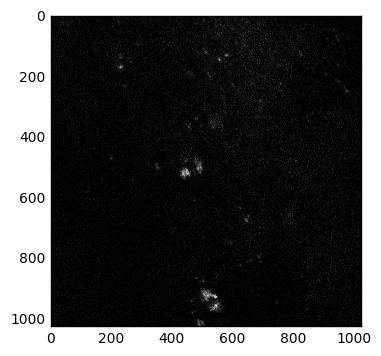

<Container object of 50 artists>

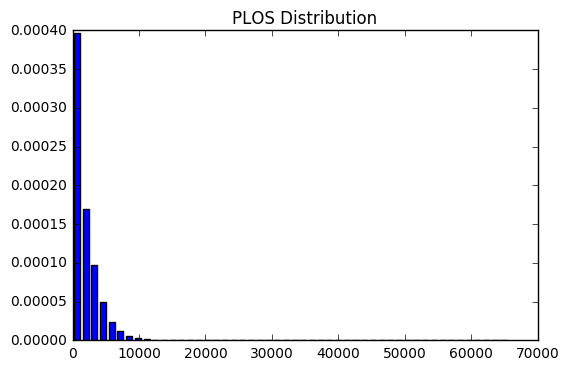

In [28]:
import sys
sys.path.insert(0, '../code/functions/')
import connectLib as cLib
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
import math
from cluster import Cluster
from mpl_toolkits.mplot3d import Axes3D
import cv2
import plosLib as pLib
import mouseVis as mv
import tiffIO as tIO
import hyperReg as hype
from scipy import ndimage

dataSubset = tIO.unzipChannels(tIO.loadTiff('../data/SEP-GluA1-KI_tp2.tif'))[0][0:5]
plt.imshow(dataSubset[0], cmap="gray")
plt.show()

#displaying distribution of plos outputs
fig = plt.figure()
plt.title("PLOS Distribution")
hist, bins = np.histogram(dataSubset, bins=50, normed=True)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.bar(center, hist, align='center', width=width)



In [ ]:
def clusterThresh(volume, threshold=250):
    # the connectivity structure matrix
    s = [[[1 for k in xrange(3)] for j in xrange(3)] for i in xrange(3)]

    # find connected components
    labeled, nr_objects = ndimage.label(volume, s)

    #volume thresholding
    mask = labeled > labeled.mean()
    sizes = ndimage.sum(mask, labeled, range(nr_objects + 1))
    mask_size = sizes < threshold
    remove_pixel = mask_size[labeled]
    labeled[remove_pixel] = 0
    labeled, nr_objects = ndimage.label(labeled, s)

    #convert labeled to Sparse
    sparseLabeledIm = np.empty(len(labeled), dtype=object)
    for i in range(len(labeled)):
        sparseLabeledIm[i] = sparse.csr_matrix(labeled[i])

    clusterList = []

    #converting to clusterList
    for label in range(1, nr_objects):

        memberList = []

        for z in range(len(sparseLabeledIm)):
            memberListWithoutZ = np.argwhere(sparseLabeledIm[z] == label)
            memberListWithZ = [[z] + list(tup) for tup in memberListWithoutZ]
            memberList.extend(memberListWithZ)

        if not len(memberList) == 0:
            clusterList.append(Cluster(memberList))

    return clusterList

In [29]:
#pipeline without plos and with binary thresholding instead
def binaryThreshold(img, percentile=90):
    img = (img/256).astype('uint8')
    threshImg = np.zeros_like(img)
    percentile = np.percentile(img, percentile)
    for i in range(len(img)):
        threshImg[i] = cv2.threshold(img[i], percentile, 255, cv2.THRESH_BINARY)[1]
    return threshImg

def analyzeTimepoint(tiffImage, plosNeighborhood = 1, plosLowerZBound =0, plosUpperZBound =5, debug=False):
    #finding the clusters after plosPipeline
    #plosOut = pLib.pipeline(tiffImage, plosNeighborhood, plosLowerZBound, plosUpperZBound)
    #binarize output of plos lib
    bianOut = binaryThreshold(tiffImage, 80)
    
    #dilate the output based on neigborhood size
    #for i in range(int((plosNeighborhood+plosUpperZBound+plosLowerZBound)/3.)):
    #   bianOut = ndimage.morphology.binary_dilation(bianOut).astype(int)
    #run connected component
    connectList = cLib.clusterThresh(bianOut)
    
    if debug:
        print connectList, bianOut

    return connectList

In [30]:
clusters = analyzeTimepoint(dataSubset)
clusterMembers = []
for cluster in clusters:
    for member in cluster.members:
        clusterMembers.append(member)

In [32]:
print len(clusterMembers)


863579


Average Volume: 16.4409816091


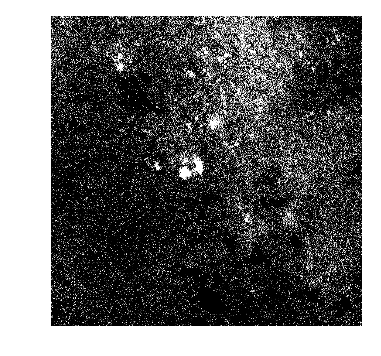

In [44]:
displayIm = np.zeros_like(dataSubset)
volumeList = []
for cluster in range(len(clusters)):
    volumeList.append(clusters[cluster].getVolume())
    for member in range(len(clusters[cluster].members)):
        z, y, x = clusters[cluster].members[member]
        displayIm[z][y][x] = 255
print "Average Volume: " + str(np.mean(volumeList))

plt.imshow(displayIm[0], cmap = "gray")
plt.axis('off')
plt.show()

In [46]:
print len(clusters)

52526


In [47]:
import cv2
cv2.imshow('hello', displayIm[0])
cv2.waitKey()

13